# Tracking through the 3D map of a magnetic element
We want to transport a bunch of Carbon ions through the realistic field map of a strongly bent dipole magnet.

In [1]:
%plot -f SVG

In [2]:
RF_Track;


RF-Track, version 2.3.3a0

Copyright (C) 2016-2025 CERN, Geneva, Switzerland. All rights reserved.

Author and contact:
 Andrea Latina <andrea.latina@cern.ch>
 BE-ABP Group
 CERN
 CH-1211 GENEVA 23
 SWITZERLAND

This software is distributed under a CERN proprietary software
license in the hope that it will be useful, but WITHOUT ANY WARRANTY;
not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

See the COPYRIGHT and LICENSE files at the top-level directory of
the RF-Track download area: https://gitlab.cern.ch/rf-track

RF-Track was compiled with GSL-2.7 and fftw-3.3.10



In [3]:
addpath('scripts/')

## Define the key parameters
In the function ```init_ion```, we specify the key parameters of the reference particle.

In [4]:
ion = init_ion()

ion =

  scalar structure containing the fields:

    mass = 1.1259e+04
    Z = 6
    P_ref = 1.1951e+04
    V_ref = 0.7279
    B_rho = 6.6439
    P_over_q = 1991.8
    E_tot = 1.6419e+04



## Let's load the field map

In [5]:
function V = init_volume()
    RF_Track;

    % Load field map from disk
    load('data/Dipole_Fieldmap.dat.gz');

    % Create RF-Track element
    S = Static_Magnetic_FieldMap (Bx, ... % T
                                  By, ...
                                  Bz, ...
                                  x_min_mm/1e3, ... % m
                                  y_min_mm/1e3, ... % m
                                  hx/1e3, ... % m
                                  hy/1e3, ... % m
                                  hz/1e3);    % m

    % Init Volume
    V = Volume();
    V.add_ref (S, 0, 0, 0, 'center');
    
    V.odeint_algorithm = 'rk2';
    V.odeint_epsabs = 1e-8;
    V.tt_dt_mm = 10;
    V.dt_mm = 0.1; % mm/c
    
    # Define the reference particle
    ion = init_ion ();
    P0 = Bunch6dT (ion.mass, 0, ion.Z, [ 0 0 0 0 0 ion.P_ref ]);

    % Set boudaries
    traj_len = 700; % mm
    t_mm = traj_len / ion.V_ref; % [mm/c]
    
    V.set_s0(0.0);
    V.set_s1(P0, t_mm);

endfunction

We can initialize the volume now

In [6]:
V = init_volume();

## Let's plot the field
Using get_field over the plane $XZ$

In [7]:
Xa = linspace(-150, 150, 101); % mm
Za = linspace(-700, 700, 201); % mm

%% XZ Plane
[X,Z] = meshgrid(Xa, Za);

[E,B] = V.get_field(X(:), 0, Z(:), 0);

Bx = reshape(B(:,1), size(X));
By = reshape(B(:,2), size(X));
Bz = reshape(B(:,3), size(X));

Here we plot it

In [8]:
figure;
pcolor(Za, Xa, By');
h = colorbar;
shading flat
xlabel('z [mm]')
ylabel('x [mm]')
ylabel (h, 'B_y [T]');

## Let's perform tracking
We perform tracking in Lattice, to ease integration with downstream beamline elements. First, let's create a bunch.

In [9]:
Twiss = Bunch6d_twiss();
Twiss.beta_x = 1; % m
Twiss.beta_y = 1; % m
Twiss.emitt_x = 1; % mm.mrad, normalised emittance 
Twiss.emitt_y = 1; % mm.mrad
Twiss.sigma_t = 1; % mm/c
Twiss.sigma_pt = 1; % permille, normalised energy spread
Twiss.disp_x = 0; % m, initial dispersion

In [10]:
N_particles = 1000;

B0 = Bunch6d_QR (ion.mass, 0.0, ion.Z, ion.P_ref, Twiss, N_particles);

In [11]:
V.set_tt_nsteps(10);

L = Lattice();
L.append_ref (V);

tic
B1 = L.track(B0);
toc

Elapsed time is 16.0116 seconds.


Let's retrieve the phase space and the transport table

In [12]:
I1 = B1.get_phase_space('%x %Px %y %Py %t %E');

TT = L.get_transport_table('%S %beta_x %beta_y %disp_x %disp_px %emitt_x %emitt_y %emitt_4d %emitt_6d');

## Let's do some plots

In [13]:
figure;
hold on
plot(TT(:,1), TT(:,2), 'displayname', 'beta_x', 'linewidth', 2);
plot(TT(:,1), TT(:,3), 'displayname', 'beta_y', 'linewidth', 2);
legend('location', 'northwest');
xlabel('S [m]')
ylabel('beta function [m]');

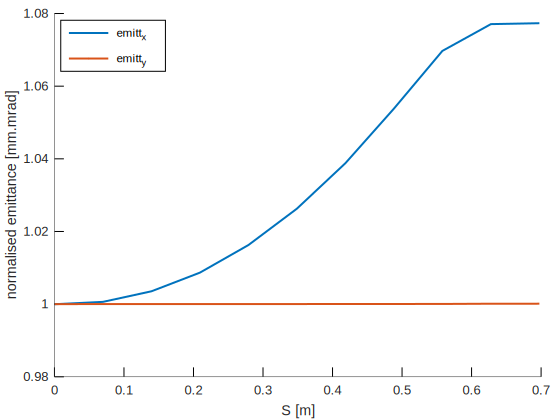

In [14]:
figure;
hold on
plot(TT(:,1), TT(:,6), 'displayname', 'emitt_x', 'linewidth', 2);
plot(TT(:,1), TT(:,7), 'displayname', 'emitt_y', 'linewidth', 2);
legend('location', 'northwest');
xlabel('S [m]')
ylabel('normalised emittance [mm.mrad]');

# Interlude
### Fitting the transfer matrix

In [15]:
M0 = B0.get_phase_space('%x %xp %y %yp %dt %pt');
M1 = B1.get_phase_space('%x %xp %y %yp %dt %pt');

x0  = M0(:,1);
xp0 = M0(:,2);
y0  = M0(:,3);
yp0 = M0(:,4);
t0  = M0(:,5);
d0  = M0(:,6);

x1  = M1(:,1);
xp1 = M1(:,2);
y1  = M1(:,3);
yp1 = M1(:,4);
t1  = M1(:,5);
d1  = M1(:,6);

I = ones (size(x0));
I1 = [ x1 xp1 y1 yp1 t1 d1 ];
I0 = [ I ... % K - 0th order
       x0 xp0 y0 yp0 t0 d0 ... % R - 1st order
       x0.^2 xp0.^2 y0.^2 yp0.^2 t0.^2 d0.^2 ... % T 2nd-order
       x0.*xp0 x0.*y0 x0.*yp0 x0.*t0 x0.*d0 ...  % T
       xp0.*y0 xp0.*yp0 xp0.*t0 xp0.*d0 ... % T
       y0.*yp0 y0.*t0 y0.*d0 ... % T
       yp0.*t0 yp0.*d0 ... % T
       t0.*d0 ... % T
       d0.*d0.*d0 d0.*d0.*t0 d0.*d0.*x0 d0.*d0.*xp0 d0.*d0.*y0 ... % U - 3rd order
       d0.*d0.*yp0 d0.*t0.*t0 d0.*t0.*x0 d0.*t0.*xp0 d0.*t0.*y0 ... % U
       d0.*t0.*yp0 d0.*x0.*x0 d0.*x0.*xp0 d0.*x0.*y0 d0.*x0.*yp0 ... % U
       d0.*xp0.*xp0 d0.*xp0.*y0 d0.*xp0.*yp0 d0.*y0.*y0 ... % U
       d0.*y0.*yp0 d0.*yp0.*yp0 t0.*t0.*t0 t0.*t0.*x0 t0.*t0.*xp0 ... % U
       t0.*t0.*y0 t0.*t0.*yp0 t0.*x0.*x0 t0.*x0.*xp0 t0.*x0.*y0 ... % U
       t0.*x0.*yp0 t0.*xp0.*xp0 t0.*xp0.*y0 t0.*xp0.*yp0 ... % U
       t0.*y0.*y0 t0.*y0.*yp0 t0.*yp0.*yp0 x0.*x0.*x0 x0.*x0.*xp0 ... % U
       x0.*x0.*y0 x0.*x0.*yp0 x0.*xp0.*xp0 x0.*xp0.*y0 ... % U
       x0.*xp0.*yp0 x0.*y0.*y0 x0.*y0.*yp0 x0.*yp0.*yp0 ... % U
       xp0.*xp0.*xp0 xp0.*xp0.*y0 xp0.*xp0.*yp0 xp0.*y0.*y0 ... % U
       xp0.*y0.*yp0 xp0.*yp0.*yp0 y0.*y0.*y0 y0.*y0.*yp0 ... % U
       y0.*yp0.*yp0 yp0.*yp0.*yp0 ]; % U

M = (I1') / (I0');
K = M(:,1) # 0th order
R = M(:,2:7) # 1st order
T = M(:,8:28); # 2nd order
U = M(:,29:end); # 3rd order

% Example of Tracking
I1_predicted = ([ K R T U ] * I0')';

K =

  -2.0966e-01
  -5.1372e-01
   9.0908e-05
   2.8405e-04
   4.4181e-02
   2.8569e-12

R =

   1.1650e+00   7.2749e-01   7.7962e-05  -6.2293e-05  -4.6799e-04   1.4924e-01
   3.3735e-01   1.0691e+00   2.9152e-04  -1.2878e-04  -1.1016e-03   3.6477e-01
   5.4899e-05  -2.6189e-05   8.6577e-01   6.8100e-01  -7.3019e-05  -2.0479e-05
   6.2066e-05  -2.8209e-05  -1.6235e-01   1.0272e+00  -1.9076e-04  -1.1348e-04
   3.7460e-01   1.0544e-01   3.6599e-06  -1.0108e-05   9.9996e-01  -6.1126e-01
   3.0714e-12   1.5263e-12  -2.1508e-13   2.7134e-13  -3.4725e-13   1.0000e+00



In [16]:
det(R)

ans = 1.0000


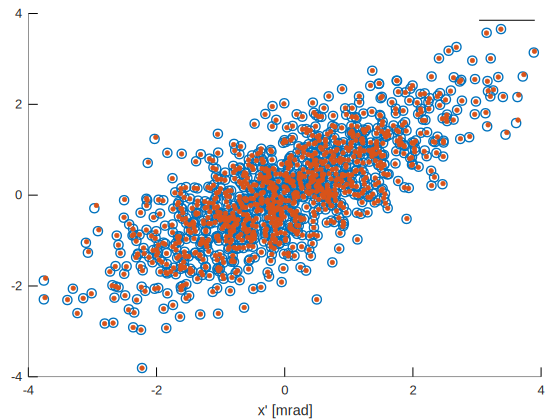

In [17]:
figure;
hold on;
scatter(I1(:,1), I1(:,2), 150, 'o')
scatter(I1_predicted(:,1), I1_predicted(:,2), '.')
legend('rk2', 'transfer map');
xlabel('x [mm]')
xlabel('x'' [mrad]')